In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [59]:
ord_encoding = OrdinalEncoder()
mm_scale = MinMaxScaler()

In [60]:
df = pd.read_csv('data//restaurant_info.csv')
re_cu_loc = pd.read_csv('data//re_cu_loc.csv')
df.head()

restaurant_id                                  Name  Rating  \
0              1  Itminaan Matka Biryani - Slow Cooked     4.0   
1              2                              Chicking     3.7   
2              3                           Ludos Pizza     4.0   
3              4                         Auntie Fung's     4.0   
4              5                    Burgers And Shakes     4.0   

                                             cusines  delivery_review_number  \
0                    Biryani, North Indian, Desserts                      64   
1                           Fast Food, Burger, Pizza                     622   
2              Pizza, Fast Food, Desserts, Beverages                     152   
3  Asian, Thai, Vietnamese, Japanese, Indonesian,...                    1491   
4      Burger, Sandwich, Fast Food, Shake, Beverages                      18   

                  location  Longitude   Latitude  \
0        Ulsoor, Bangalore  77.624670  12.977879   
1   Rajajinagar, Bangalore  77.554883  12.988234   
2  Marathahalli, Bangalore  77.698416  12.955257   
3   Indiranagar, Bangalore  77.640467  12.973291   
4   Indiranagar, Bangalore  77.640467  12.973291   

                                     Restaurant_link  price_for_one  
0  https://www.zomato.com/bangalore/itminaan-matk...            250  
1  https://www.zomato.com/bangalore/chicking-1-ra...            200  
2  https://www.zomato.com/bangalore/ludos-pizza-2...            300  
3  https://www.zomato.com/bangalore/auntie-fungs-...            300  
4  https://www.zomato.com/bangalore/burgers-and-s...            100

In [61]:
len(df['Name'].unique())

4095

In [62]:
df.isna().sum()

restaurant_id             0
Name                      0
Rating                    0
cusines                   0
delivery_review_number    0
location                  0
Longitude                 0
Latitude                  0
Restaurant_link           0
price_for_one             0
dtype: int64

In [63]:
df.dtypes

restaurant_id               int64
Name                       object
Rating                    float64
cusines                    object
delivery_review_number      int64
location                   object
Longitude                 float64
Latitude                  float64
Restaurant_link            object
price_for_one               int64
dtype: object

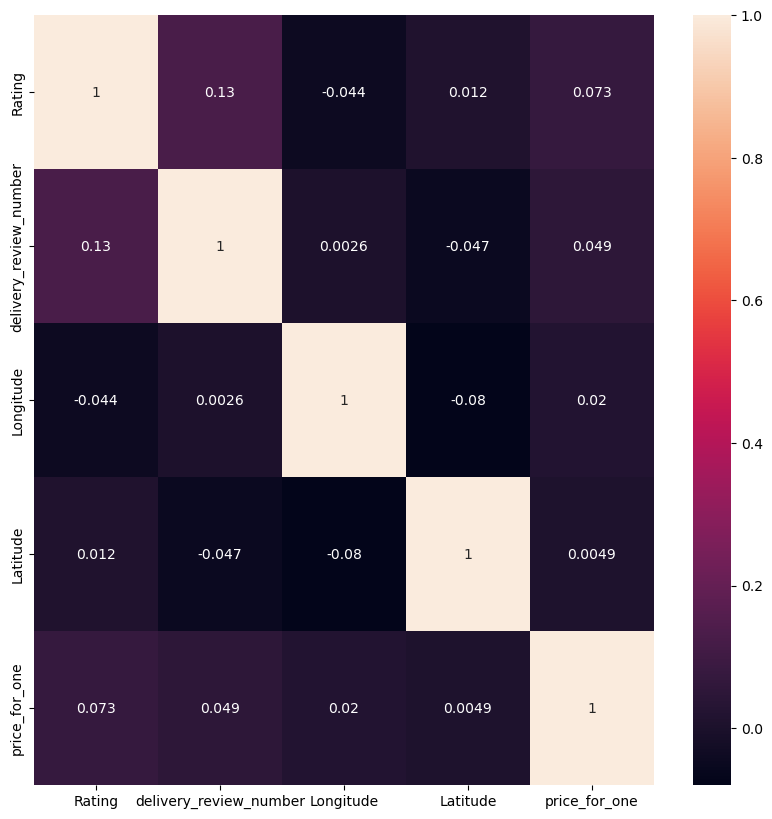

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(columns='restaurant_id').corr(),annot = True)
plt.show()

In [65]:
px.density_mapbox(df,lon=df['Longitude'],lat=df['Latitude'],
                        mapbox_style="open-street-map",hover_name=df['Name'],radius=4,title='Area-wise distribution of restaurant')

In [66]:
fig = px.scatter(df, x="Longitude", y="Latitude",color="price_for_one",
                 hover_name="Name", size_max=60)
fig.show()

# extracting multiple cusines from the cusines column end goal was create a table where both restaurant and cusines will be distinct and restaurent and cusines both serves as a primary key

In [67]:
cusines_info = df['cusines'].str.split(',',expand=True)
cusines_info.columns = ['cusines1','cusines2','cusines3',
                        'cusines4','cusines5','cusines6',
                        'cusines7','cusines8']

cusines_info['Restaurant'] = df['Name']
cusines_info['price_for_one'] = df['price_for_one']
res_cusine_info=pd.melt(cusines_info, id_vars='Restaurant',
                        value_vars=['cusines1','cusines2','cusines3',
                                    'cusines4','cusines5','cusines6',
                                    'cusines7','cusines8'])
f_res_cusine_info = res_cusine_info.merge(cusines_info,on='Restaurant',how='left')
f_res_cusine_info.rename(columns={'value':'Cusines_all'},inplace=True)
f_res_cusine_info = f_res_cusine_info[['Restaurant','Cusines_all','price_for_one']]


In [68]:
f_res_cusine_info['price_for_one'].max()

2000

# return all expensive resturant for all cusines

In [69]:
selected_cusine_name = 'Ice Cream'
search_res_by_cusines_max=f_res_cusine_info.groupby('Cusines_all').agg({'price_for_one':'max'}).reset_index()
search_res_by_cusines_max=search_res_by_cusines_max.merge(f_res_cusine_info,on=['Cusines_all','price_for_one'],how='left')
search_res_by_cusines_max.rename(columns={'price_for_one': 'MaxPrice_for_one'},inplace=True)
search_res_by_cusines_max.drop_duplicates(subset='Restaurant')

Cusines_all  MaxPrice_for_one                    Restaurant
0                              250  ITC Sunfeast Baked Creations
121       Afghan               600   Gufha - The President Hotel
122     American              1400                Hard Rock Cafe
123       Andhra               600     Kudla - Hotel Ramanashree
124      Arabian               500                        Zaatar
...          ...               ...                           ...
1815     Turkish               150                     Tarbouche
1816  Vietnamese               600         The Asian Curry House
1817      Waffle               250                  Waffle Magic
1818       Wraps               250                 Burger Bistro
1819       Wraps               250                       Wrap It

[180 rows x 3 columns]

# return the expensive restaurent for selected cusine

In [70]:
selected_cusine_name = 'Ice Cream'
search_res_by_cusines_max=f_res_cusine_info[f_res_cusine_info['Cusines_all']==selected_cusine_name].groupby('Cusines_all').agg({'price_for_one':'max'}).reset_index()
search_res_by_cusines_max=search_res_by_cusines_max.merge(f_res_cusine_info,on=['Cusines_all','price_for_one'],how='left')
search_res_by_cusines_max.rename(columns={'price_for_one': 'MaxPrice_for_one'},inplace=True)
search_res_by_cusines_max.drop_duplicates(subset='Restaurant')

Cusines_all  MaxPrice_for_one   Restaurant
0   Ice Cream               400  Häagen Dazs

# return all cheap resturant for each cusines

In [71]:
selected_cusine_name = 'Ice Cream'
search_res_by_cusines_min=f_res_cusine_info.groupby('Cusines_all').agg({'price_for_one':'min'}).reset_index()
search_res_by_cusines_min=search_res_by_cusines_min.merge(f_res_cusine_info,on=['Cusines_all','price_for_one'],how='left')
search_res_by_cusines_min.rename(columns={'price_for_one': 'MinimumPrice_for_one'},inplace=True)
search_res_by_cusines_min.drop_duplicates(subset='Restaurant')

Cusines_all  MinimumPrice_for_one                              Restaurant
0                                  250            ITC Sunfeast Baked Creations
121       Afghan                   100                            Sharief Bhai
148       Afghan                   100                         Zahra's Kitchen
149     American                   100                               Andrila's
150       Andhra                   100                         Fresh And Tasty
...          ...                   ...                                     ...
3043  Vietnamese                   250                                 Hao Chi
3059      Waffle                   150                                Wowffles
3062      Waffle                   150                  The Belgian Waffle Co.
3175      Waffle                   150  Diwali Specials By CakeZone - Pure Veg
3208       Wraps                   150                               Carry Out

[405 rows x 3 columns]

# return the cheap restaurent for selected cusine

In [72]:
selected_cusine_name = 'Ice Cream'
search_res_by_cusines_min=f_res_cusine_info[f_res_cusine_info['Cusines_all']==selected_cusine_name].groupby('Cusines_all').agg({'price_for_one':'min'}).reset_index()
search_res_by_cusines_min=search_res_by_cusines_min.merge(f_res_cusine_info,on=['Cusines_all','price_for_one'],how='left')
search_res_by_cusines_min.rename(columns={'price_for_one': 'MinimumPrice_for_one'},inplace=True)
search_res_by_cusines_min.drop_duplicates(subset='Restaurant')

Cusines_all  MinimumPrice_for_one  \
0    Ice Cream                    50   
2    Ice Cream                    50   
15   Ice Cream                    50   

                                   Restaurant  
0   The Brooklyn Creamery - Healthy Ice Cream  
2                              Bowring Kulfis  
15                          Mandara Ice Cream

In [73]:
cusines_info.melt()

variable      value
0           cusines1    Biryani
1           cusines1  Fast Food
2           cusines1      Pizza
3           cusines1      Asian
4           cusines1     Burger
...              ...        ...
75885  price_for_one        250
75886  price_for_one        400
75887  price_for_one        150
75888  price_for_one        250
75889  price_for_one        200

[75890 rows x 2 columns]

In [74]:
loc_lst = [i[0] for i in df['location'].str.split(',')]
df['location'] = loc_lst

# location wise restaurant count and number of delivery_review_number more than 1000

In [75]:
loc_wise_review_df = pd.DataFrame(df.groupby(['location']).agg({'delivery_review_number':'sum','Name':'count'}))
loc_wise_review_df=loc_wise_review_df.rename(columns={'Name':'Number_of_restaurant',}).reset_index()
loc_wise_review_df[loc_wise_review_df['delivery_review_number']>1000].sort_values(by='delivery_review_number',ascending=False)

location  delivery_review_number  Number_of_restaurant
53                    HSR                 1654543                   360
8                     BTM                 1574703                   371
100          Marathahalli                 1043520                   280
38        Electronic City                 1039154                   458
68               JP Nagar                  794279                   286
..                    ...                     ...                   ...
162  Windmills Craftworks                    1766                     2
0          1 MG Road Mall                    1692                     3
32           Coastal King                    1614                     1
153          VR Bengaluru                    1099                     2
126    Royal Orchid Hotel                    1045                     1

[126 rows x 3 columns]

# Location wise number of less rated restaurant

In [76]:
df[df['Rating']<=df['Rating'].unique().mean()][['location','Name']].groupby('location').agg({'Name':'count'}).sort_values(by='Name',ascending=False).rename(columns={'Name':'Number_of_less_rated_restaurant'}).head()

Number_of_less_rated_restaurant
location                                        
Electronic City                              109
Whitefield                                    84
BTM                                           72
HSR                                           51
Marathahalli                                  41

# area wise cheap and expensive restaurant

In [77]:
area_wise_res =df.groupby(['location','Name']).agg({'price_for_one':'mean'}).reset_index()

In [78]:
area_wise_cheap_res=area_wise_res.groupby('location').min().rename(columns={'price_for_one':'average_price_for_one','Name':'cheap_restaurant'}).reset_index()
area_wise_expensive_res=area_wise_res.groupby('location').max().rename(columns={'price_for_one':'average_price_for_one','Name':'expensive_restaurant'}).reset_index()

In [79]:
area_wise_cheap_res.merge(area_wise_expensive_res,on='location',how='inner')

location                cheap_restaurant  \
0                          1 MG Road Mall                        Fruitify   
1                        153 Biere Street           SLV Corner Restaurant   
2                       Abhimaani Vasathi                   Coastal Spice   
3    Aloft Bengaluru Cessna Business Park                 Nandhini Deluxe   
4                             Aloft Hotel           Dot.yum - Aloft Hotel   
..                                    ...                             ...   
160                            Whitefield                89 Express Dhaba   
161                         Wilson Garden                  Ambur Biriyani   
162                  Windmills Craftworks                  Oota Bangalore   
163                             Yelahanka  Asia Kitchen By Mainland China   
164                           Yeshwantpur       7-Star Ambur Dum Biriyani   

     average_price_for_one_x      expensive_restaurant  \
0                      175.0                  Yauatcha   
1                      400.0     SLV Corner Restaurant   
2                      450.0             Coastal Spice   
3                      400.0           Nandhini Deluxe   
4                     1000.0     Dot.yum - Aloft Hotel   
..                       ...                       ...   
160                     50.0  Zomoz - The Momo Company   
161                     50.0          Ying Zheng China   
162                    500.0      Windmills Craftworks   
163                     50.0                 Tarbouche   
164                     50.0       Zam Zam Kabab House   

     average_price_for_one_y  
0                     1150.0  
1                      400.0  
2                      450.0  
3                      400.0  
4                     1000.0  
..                       ...  
160                   1000.0  
161                    400.0  
162                   1400.0  
163                    500.0  
164                    700.0  

[165 rows x 5 columns]

# number of restaaurant for each cusines

In [80]:
cusines_wise_Number_of_res=f_res_cusine_info.groupby('Cusines_all').agg({'Restaurant':'count'}).reset_index()
cusines_wise_Number_of_res.sort_values(by='Restaurant',ascending=False)

Cusines_all  Restaurant
11        Beverages       16611
23         Desserts       15968
25        Fast Food       12006
62     North Indian        6982
20          Chinese        5533
..              ...         ...
117  Cuisine Varies           1
152           Parsi           1
151         Pancake           1
149        Oriental           1
111         Burmese           1

[175 rows x 2 columns]

# phase 2

## preffererd location wise popular cusines

In [81]:
re_cu_data = f_res_cusine_info.groupby(['Restaurant','Cusines_all']).mean().reset_index()
res_loc = df.rename(columns={'Name':'Restaurant'})[['Restaurant','location']]
loc_wise_cuisine=re_cu_loc.groupby(['location','Cusines_all']).agg({'Cusines_all':'count'})
loc_wise_cuisine=loc_wise_cuisine.rename(columns={'Cusines_all':'Available_in_restaurant'}).reset_index()
loc_wise_populer_cuisine=loc_wise_cuisine.groupby('location').max().reset_index()
loc_wise_populer_cuisine=loc_wise_populer_cuisine.rename(columns={'Cusines_all':'Populer cusines'}).drop(columns='Available_in_restaurant')

In [82]:
prefferd_loc = 'Marathahalli'

loc_wise_populer_cuisine[loc_wise_populer_cuisine['location']==prefferd_loc].values[0][1]

'Waffle'

# prefferd location wise average price for 1

In [83]:
loc_wise_avg_priceforOne=df.groupby('location').agg({'price_for_one':'mean'}).reset_index()
loc_wise_avg_priceforOne=loc_wise_avg_priceforOne.rename(columns={'price_for_one':'Average_price_for_1'})

In [84]:
loc_wise_avg_priceforOne[loc_wise_avg_priceforOne['location']==prefferd_loc].values[0][1]

217.76785714285714

# preffered location wise popular restaurant

In [85]:
loc_wise_pop_res=df.groupby(['location','Name','cusines']).agg({'delivery_review_number':'max'}).reset_index().groupby('location').max().reset_index()
loc_wise_pop_res=loc_wise_pop_res.drop(columns='delivery_review_number')
loc_wise_pop_res= loc_wise_pop_res.rename(columns={'Name':'Popular Restaurant','cusines':'Available cusines'})

In [86]:
loc_wise_pop_res[loc_wise_pop_res['location']==prefferd_loc].values

array([['Marathahalli', 'ZAZA 22 Spice Awadhi Biryani',
        'Waffle, Pancake, Desserts, Beverages, Ice Cream']], dtype=object)

# available cusines at preffered location wise popular restaurant¶

In [87]:
loc_wise_pop_res[loc_wise_pop_res['location']==prefferd_loc].values[0][2]

'Waffle, Pancake, Desserts, Beverages, Ice Cream'

# most popular restaurant for prefferd cusine near preffered location

In [88]:
temp_data=f_res_cusine_info.groupby(['Restaurant','Cusines_all']).mean().reset_index()
res_rating = df.rename(columns={'Name':'Restaurant'})[['Restaurant','delivery_review_number','location']]
temp = temp_data.merge(res_rating,how='left',on='Restaurant')
temp2=temp.groupby(['Cusines_all','Restaurant']).max().reset_index().groupby('Restaurant').max().reset_index()

In [89]:
temp2[(temp2['Cusines_all']== selected_cusine_name)&(temp2['location']== prefferd_loc)]['Restaurant'].values

array(['Iceberg Organic Icecreams', 'Mountain Creamery'], dtype=object)

In [90]:
f_res_cusine_info

Restaurant Cusines_all  price_for_one
0       Itminaan Matka Biryani - Slow Cooked     Biryani            250
1       Itminaan Matka Biryani - Slow Cooked     Biryani            250
2       Itminaan Matka Biryani - Slow Cooked     Biryani            250
3       Itminaan Matka Biryani - Slow Cooked     Biryani            250
4       Itminaan Matka Biryani - Slow Cooked     Biryani            250
...                                      ...         ...            ...
342339                          Mega Biryani        None            200
342340                          Mega Biryani        None            100
342341                          Mega Biryani        None            200
342342                          Mega Biryani        None            100
342343                          Mega Biryani        None            200

[342344 rows x 3 columns]

In [91]:
f_res_cusine_info.duplicated().sum()

319843

In [92]:
f_res_cusine_info.drop_duplicates(inplace=True)

In [93]:
f_res_cusine_info=f_res_cusine_info.reset_index()

In [94]:
f_res_cusine_info=f_res_cusine_info.drop(columns='index')
f_res_cusine_info

Restaurant Cusines_all  price_for_one
0      Itminaan Matka Biryani - Slow Cooked     Biryani            250
1      Itminaan Matka Biryani - Slow Cooked     Biryani            350
2                                  Chicking   Fast Food            200
3                               Ludos Pizza       Pizza            300
4                             Auntie Fung's       Asian            300
...                                     ...         ...            ...
22496                  Abhinandana Gardenia   Beverages            300
22497                             Roti Ghar   Beverages            150
22498                       Gold Rush Brews      Burger            800
22499                         Thyme & Whisk        None            700
22500                    Master Dum Biryani        None            250

[22501 rows x 3 columns]

In [95]:
df

restaurant_id                                  Name  Rating  \
0                 1  Itminaan Matka Biryani - Slow Cooked     4.0   
1                 2                              Chicking     3.7   
2                 3                           Ludos Pizza     4.0   
3                 4                         Auntie Fung's     4.0   
4                 5                    Burgers And Shakes     4.0   
...             ...                                   ...     ...   
7584            258                     BOX8 - Desi Meals     4.3   
7585           4061                   The Bangalore Dhaba     3.9   
7586           4062            RRB Ambur Hot Dum Biriyani     3.8   
7587           4063                               Wrap It     4.1   
7588             10                          Mega Biryani     4.0   

                                                cusines  \
0                       Biryani, North Indian, Desserts   
1                              Fast Food, Burger, Pizza   
2                 Pizza, Fast Food, Desserts, Beverages   
3     Asian, Thai, Vietnamese, Japanese, Indonesian,...   
4         Burger, Sandwich, Fast Food, Shake, Beverages   
...                                                 ...   
7584  North Indian, Wraps, Fast Food, Biryani, Desse...   
7585  North Indian, Italian, Chinese, Mughlai, Bever...   
7586                                     Biryani, Kebab   
7587                                              Wraps   
7588                                            Biryani   

      delivery_review_number           location  Longitude   Latitude  \
0                         64             Ulsoor  77.624670  12.977879   
1                        622        Rajajinagar  77.554883  12.988234   
2                        152       Marathahalli  77.698416  12.955257   
3                       1491        Indiranagar  77.640467  12.973291   
4                         18        Indiranagar  77.640467  12.973291   
...                      ...                ...        ...        ...   
7584                   21100  Bannerghatta Road  77.604190  12.952180   
7585                     154       Kalyan Nagar  77.640337  13.022142   
7586                     112           RT Nagar  77.595715  13.022720   
7587                     109         Whitefield  77.749745  12.969637   
7588                       7          Jayanagar  77.582423  12.929273   

                                        Restaurant_link  price_for_one  
0     https://www.zomato.com/bangalore/itminaan-matk...            250  
1     https://www.zomato.com/bangalore/chicking-1-ra...            200  
2     https://www.zomato.com/bangalore/ludos-pizza-2...            300  
3     https://www.zomato.com/bangalore/auntie-fungs-...            300  
4     https://www.zomato.com/bangalore/burgers-and-s...            100  
...                                                 ...            ...  
7584  https://www.zomato.com/bangalore/box8-desi-mea...            250  
7585  https://www.zomato.com/bangalore/the-bangalore...            400  
7586  https://www.zomato.com/bangalore/rrb-ambur-hot...            150  
7587  https://www.zomato.com/bangalore/wrap-it-white...            250  
7588  https://www.zomato.com/bangalore/mega-biryani-...            200  

[7589 rows x 10 columns]

# Models

In [96]:
z=f_res_cusine_info.merge(df.rename(columns={'Name':'Restaurant'}),how='left',on=['Restaurant','price_for_one'])

In [97]:
z.columns

Index(['Restaurant', 'Cusines_all', 'price_for_one', 'restaurant_id', 'Rating',
       'cusines', 'delivery_review_number', 'location', 'Longitude',
       'Latitude', 'Restaurant_link'],
      dtype='object')

In [98]:
z.isna().sum()

Restaurant                   0
Cusines_all               7336
price_for_one                0
restaurant_id                0
Rating                       0
cusines                      0
delivery_review_number       0
location                     0
Longitude                    0
Latitude                     0
Restaurant_link              0
dtype: int64

In [99]:
z.duplicated().sum()

0

In [100]:
z.dropna(inplace=True)

In [101]:
z.drop(columns=['cusines','restaurant_id','Restaurant_link'],inplace=True)

In [102]:
z.price_for_one.max()

2000

In [103]:
z.isna().sum()

Restaurant                0
Cusines_all               0
price_for_one             0
Rating                    0
delivery_review_number    0
location                  0
Longitude                 0
Latitude                  0
dtype: int64

In [104]:
z.head()

Restaurant Cusines_all  price_for_one  Rating  \
0  Itminaan Matka Biryani - Slow Cooked     Biryani            250     4.0   
1  Itminaan Matka Biryani - Slow Cooked     Biryani            250     3.8   
2  Itminaan Matka Biryani - Slow Cooked     Biryani            250     4.1   
3  Itminaan Matka Biryani - Slow Cooked     Biryani            250     3.8   
4  Itminaan Matka Biryani - Slow Cooked     Biryani            250     3.6   

   delivery_review_number               location  Longitude   Latitude  
0                      64                 Ulsoor  77.624670  12.977879  
1                      62            City Market  77.576271  12.965718  
2                     601      Bannerghatta Road  77.604190  12.952180  
3                     511       Old Airport Road  77.666395  12.958383  
4                     502  Koramangala 6th Block  77.623848  12.939025

In [105]:
z = z[z['Cusines_all']!=' ']


In [106]:
price_model_data = z.copy()

In [107]:
price_model_data.to_csv('data//price_model_data.csv')

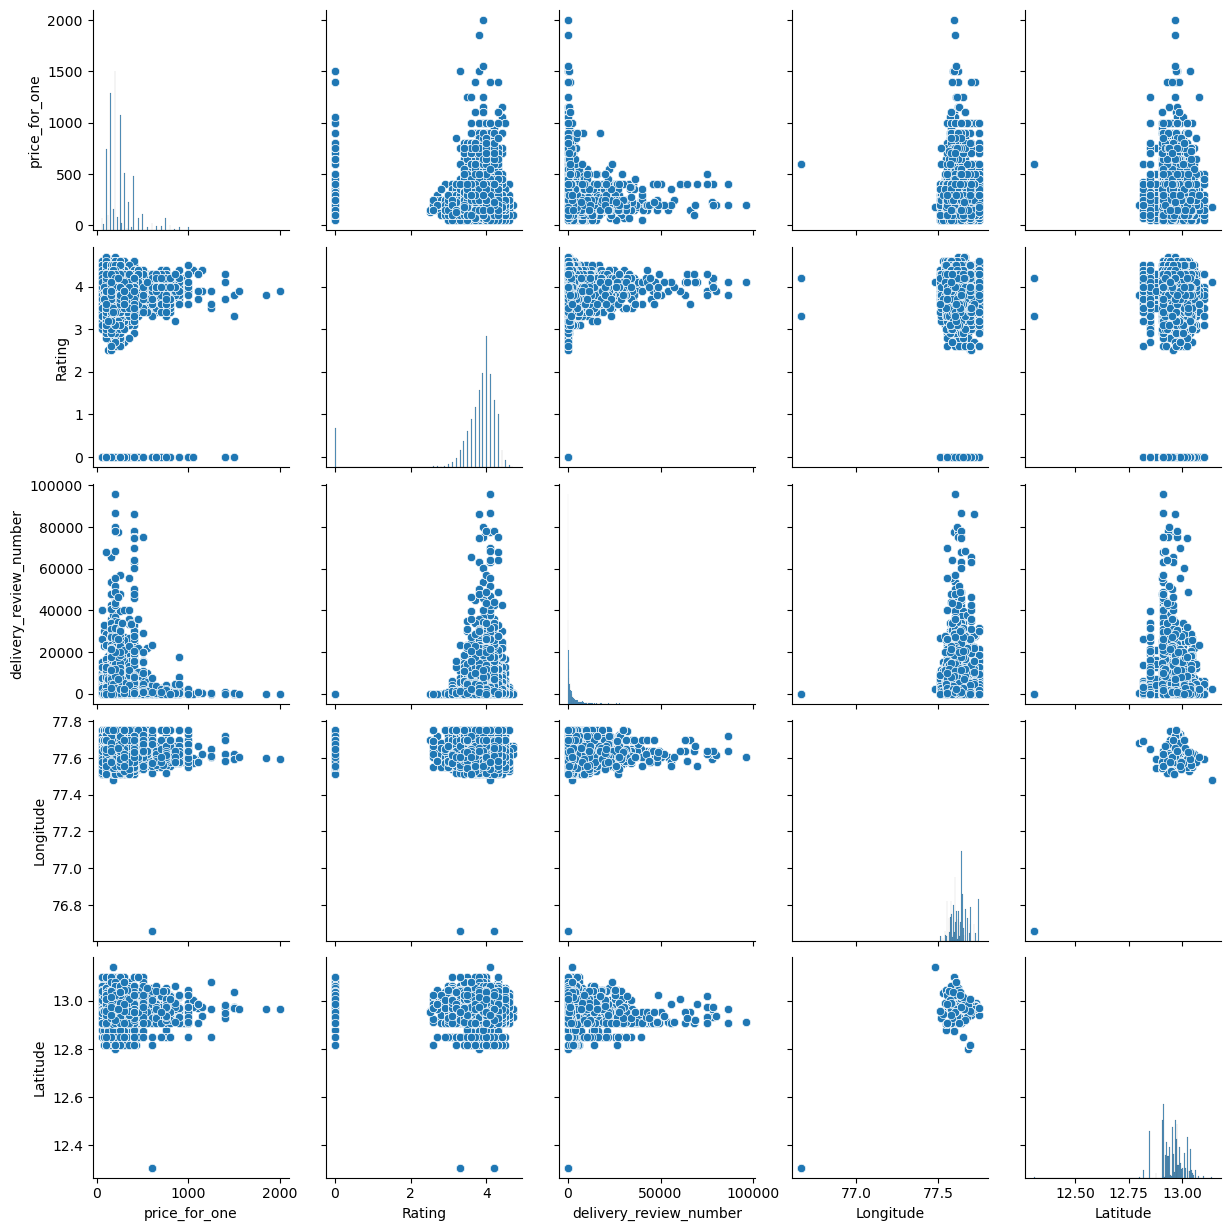

In [108]:
sns.pairplot(z)
plt.show()

In [109]:
z.columns

Index(['Restaurant', 'Cusines_all', 'price_for_one', 'Rating',
       'delivery_review_number', 'location', 'Longitude', 'Latitude'],
      dtype='object')

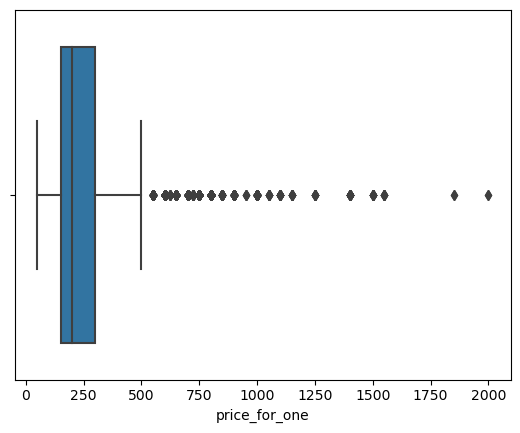

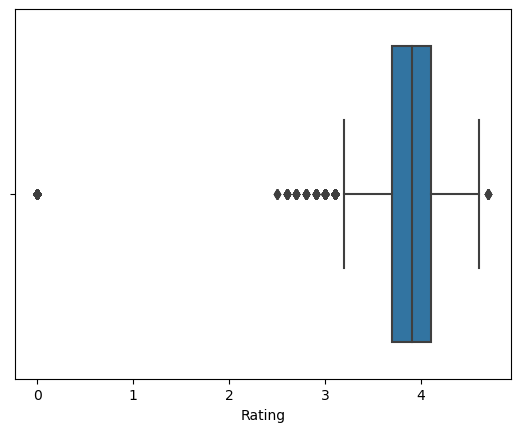

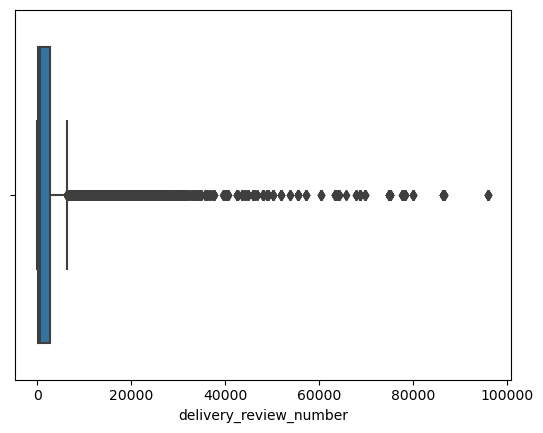

In [110]:
col = ['price_for_one','Rating','delivery_review_number']

for i in col:
    sns.boxplot(x=z[i])
    plt.show()

In [111]:
# for i in col:
#     q1 = z[i].quantile(0.25)
#     q3 = z[i].quantile(0.75)
#     iqr = q3 - q1
#     u_limit = q3 + (1.5*iqr)
#     l_limit = q1 - (1.5*iqr)
#     z = z[z[i]<u_limit]
#     z = z[z[i]>l_limit]
#     plt.figure()
#     sns.boxplot(y=i,data=z)

In [112]:
cusine_list = [i.strip().lower() for i in z['Cusines_all']]

In [113]:
z['Cusines_all'] = cusine_list

In [114]:
cusine_list

['biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'fast food',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'asian',
 'burger',
 'south indian',
 'desserts',
 'north indian',
 'north indian',
 'north indian',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'momos',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'biryani',
 'bi

In [115]:
from sklearn.preprocessing import OrdinalEncoder
ord_encoding = OrdinalEncoder()

In [116]:
ord_encoding.fit_transform(z[['Cusines_all']])

array([[14.],
       [14.],
       [14.],
       ...,
       [12.],
       [12.],
       [17.]])

In [117]:
z.drop(columns='Restaurant',inplace=True)

In [118]:
z['Cusines_encoded'] = ord_encoding.fit_transform(z[['Cusines_all']])

In [119]:
cusines_list_encoded = [i for i in z['Cusines_encoded']]
cusines_list_encoded

[14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 27.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 72.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 17.0,
 86.0,
 25.0,
 64.0,
 64.0,
 64.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 59.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 88.0,
 64.0,
 64.0,
 64.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 64.0,
 64.0,
 64.0,
 64.0,
 64.0,
 64.0,
 64.0,
 21.0,
 64.0,
 86.0,
 86.0,
 35.0,
 86.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 78.0,
 20.0,
 14.0,
 11.0,
 11.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 

In [120]:
cusines_encoded_dict = {k:v for (k,v) in zip(cusine_list,cusines_list_encoded)}
cusines_encoded_dict

{'biryani': 14.0,
 'fast food': 27.0,
 'pizza': 72.0,
 'asian': 5.0,
 'burger': 17.0,
 'south indian': 86.0,
 'desserts': 25.0,
 'north indian': 64.0,
 'momos': 59.0,
 'street food': 88.0,
 'chinese': 21.0,
 'hyderabadi': 35.0,
 'sandwich': 78.0,
 'chettinad': 20.0,
 'bengali': 11.0,
 'bakery': 8.0,
 'mexican': 54.0,
 'kerala': 44.0,
 'ice cream': 36.0,
 'beverages': 12.0,
 'healthy food': 33.0,
 'mithai': 57.0,
 'coffee': 22.0,
 'cafe': 19.0,
 'rolls': 76.0,
 'juices': 41.0,
 'andhra': 3.0,
 'continental': 23.0,
 'lebanese': 47.0,
 'mangalorean': 52.0,
 'rajasthani': 74.0,
 'steak': 87.0,
 'maharashtrian': 49.0,
 'tea': 91.0,
 'bbq': 10.0,
 'mughlai': 60.0,
 'roast chicken': 75.0,
 'north eastern': 63.0,
 'goan': 31.0,
 'seafood': 79.0,
 'italian': 39.0,
 'mishti': 56.0,
 'arabian': 4.0,
 'paan': 67.0,
 'tibetan': 94.0,
 'shawarma': 81.0,
 'shake': 80.0,
 'european': 26.0,
 'thai': 93.0,
 'awadhi': 7.0,
 'odia': 65.0,
 'afghan': 0.0,
 'american': 2.0,
 'salad': 77.0,
 'waffle': 97.0,


In [121]:
for i in z.columns:
    print(i,z[i].unique())

Cusines_all ['biryani' 'fast food' 'pizza' 'asian' 'burger' 'south indian' 'desserts'
 'north indian' 'momos' 'street food' 'chinese' 'hyderabadi' 'sandwich'
 'chettinad' 'bengali' 'bakery' 'mexican' 'kerala' 'ice cream' 'beverages'
 'healthy food' 'mithai' 'coffee' 'cafe' 'rolls' 'juices' 'andhra'
 'continental' 'lebanese' 'mangalorean' 'rajasthani' 'steak'
 'maharashtrian' 'tea' 'bbq' 'mughlai' 'roast chicken' 'north eastern'
 'goan' 'seafood' 'italian' 'mishti' 'arabian' 'paan' 'tibetan' 'shawarma'
 'shake' 'european' 'thai' 'awadhi' 'odia' 'afghan' 'american' 'salad'
 'waffle' 'vietnamese' 'finger food' 'french' 'pasta' 'japanese'
 'cuisine varies' 'bar food' 'kebab' 'mediterranean' 'african' 'sushi'
 'modern indian' 'turkish' 'tamil' 'wraps' 'gujarati' 'naga' 'pancake'
 'oriental' 'konkan' 'burmese' 'kashmiri' 'bubble tea' 'assamese' 'parsi'
 'tex-mex' 'bihari' 'sichuan' 'korean' 'middle eastern' 'panini' 'snacks'
 'iranian' 'mandi' 'lucknowi' 'british' 'nepalese' 'german' 'hot do

In [122]:
cluster_z = z[['Longitude','Latitude','price_for_one']]
cluster_z

Longitude   Latitude  price_for_one
0      77.624670  12.977879            250
1      77.576271  12.965718            250
2      77.604190  12.952180            250
3      77.666395  12.958383            250
4      77.623848  12.939025            250
...          ...        ...            ...
39476  77.630507  13.025809            400
39478  77.640467  12.973291            500
39479  77.606894  13.078474            300
39480  77.575502  12.941726            150
39481  77.695935  13.007516            800

[32137 rows x 3 columns]

In [123]:
# cluster_z['Cusines_all'] = ord_encoding.fit_transform(cluster_z[['Cusines_all']])

In [124]:
scaled_cluster_z = mm_scale.fit_transform(cluster_z)
scaled_cluster_z

array([[0.88524541, 0.80571167, 0.1025641 ],
       [0.84083988, 0.79108306, 0.1025641 ],
       [0.86645549, 0.77479894, 0.1025641 ],
       ...,
       [0.86893628, 0.92671553, 0.12820513],
       [0.84013485, 0.76222365, 0.05128205],
       [0.95063029, 0.8413611 , 0.38461538]])

In [125]:
cluster_z

Longitude   Latitude  price_for_one
0      77.624670  12.977879            250
1      77.576271  12.965718            250
2      77.604190  12.952180            250
3      77.666395  12.958383            250
4      77.623848  12.939025            250
...          ...        ...            ...
39476  77.630507  13.025809            400
39478  77.640467  12.973291            500
39479  77.606894  13.078474            300
39480  77.575502  12.941726            150
39481  77.695935  13.007516            800

[32137 rows x 3 columns]

In [126]:
scaled_cluster_z = pd.DataFrame(mm_scale.fit_transform(cluster_z),columns = ['Longitude','Latitude','price_for_one'])
scaled_cluster_z.head()

Longitude  Latitude  price_for_one
0   0.885245  0.805712       0.102564
1   0.840840  0.791083       0.102564
2   0.866455  0.774799       0.102564
3   0.923527  0.782260       0.102564
4   0.884491  0.758975       0.102564

KMeans

In [127]:
cluster_range = range(1,21)
inertia = []

In [128]:
for i in cluster_range:
    kmeans = KMeans(i)
    kmeans.fit(scaled_cluster_z)
    inertia.append(kmeans.inertia_)
    

elbow Curve

In [129]:
import plotly.express as px
px.line(x=cluster_range,y=inertia)

In [130]:
kmeans = KMeans(5)  ## Optimum no of clusters -5 from elbow curve
kmeans.fit(scaled_cluster_z)
cluster_z['Cluster_Label'] = kmeans.predict(scaled_cluster_z)

C:\Users\user\AppData\Local\Temp\ipykernel_12480\1547148288.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
px.scatter(cluster_z,x='Latitude',y='Longitude',color='Cluster_Label')

In [132]:
px.scatter(cluster_z,y='price_for_one',x='Cluster_Label')

In [133]:
cluster_z

Longitude   Latitude  price_for_one  Cluster_Label
0      77.624670  12.977879            250              0
1      77.576271  12.965718            250              0
2      77.604190  12.952180            250              0
3      77.666395  12.958383            250              3
4      77.623848  12.939025            250              4
...          ...        ...            ...            ...
39476  77.630507  13.025809            400              1
39478  77.640467  12.973291            500              1
39479  77.606894  13.078474            300              0
39480  77.575502  12.941726            150              4
39481  77.695935  13.007516            800              2

[32137 rows x 4 columns]

In [134]:
cluster_z['Cluster_Label'].unique()

array([0, 3, 4, 1, 2])

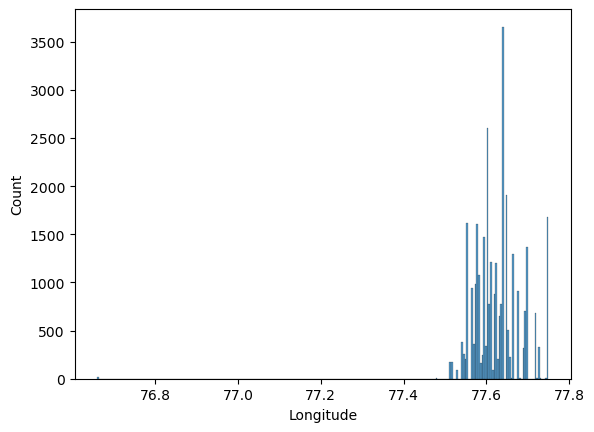

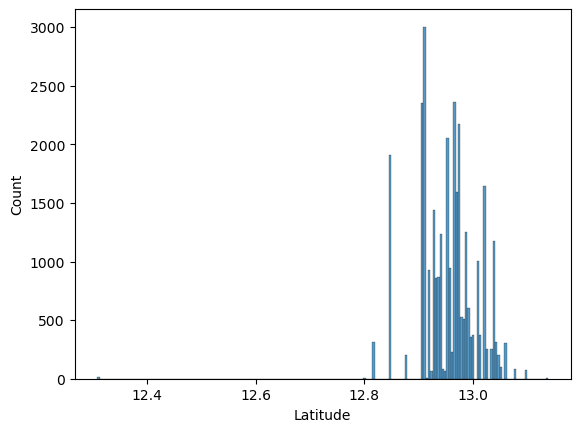

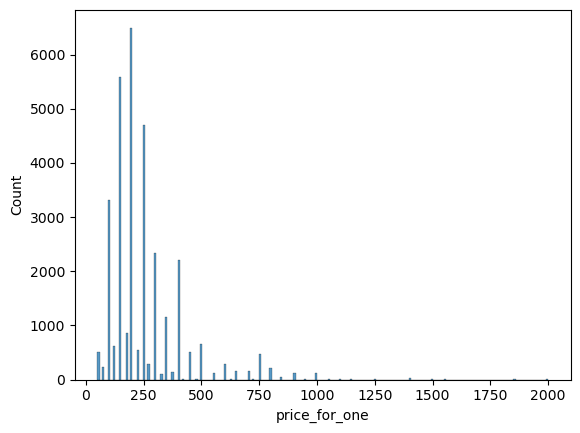

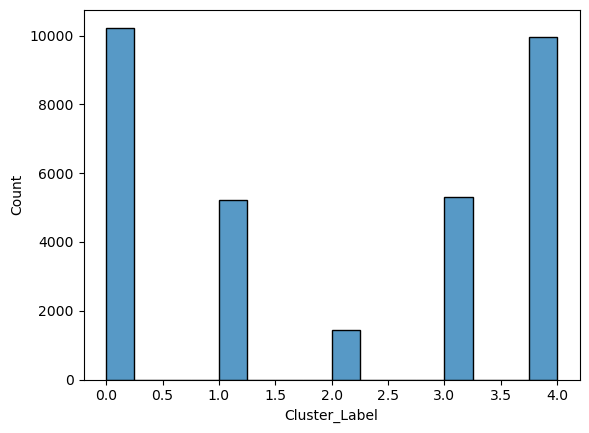

In [135]:
for i in cluster_z.columns:
    sns.histplot(cluster_z[i])
    plt.show()
    
    

In [136]:
cluster_z1 = cluster_z.copy()

In [137]:
cluster_z1['cusines'] = ord_encoding.fit_transform(z[['Cusines_all']])

In [138]:
cluster_z

Longitude   Latitude  price_for_one  Cluster_Label
0      77.624670  12.977879            250              0
1      77.576271  12.965718            250              0
2      77.604190  12.952180            250              0
3      77.666395  12.958383            250              3
4      77.623848  12.939025            250              4
...          ...        ...            ...            ...
39476  77.630507  13.025809            400              1
39478  77.640467  12.973291            500              1
39479  77.606894  13.078474            300              0
39480  77.575502  12.941726            150              4
39481  77.695935  13.007516            800              2

[32137 rows x 4 columns]

In [139]:
cluster_z1

Longitude   Latitude  price_for_one  Cluster_Label  cusines
0      77.624670  12.977879            250              0     14.0
1      77.576271  12.965718            250              0     14.0
2      77.604190  12.952180            250              0     14.0
3      77.666395  12.958383            250              3     14.0
4      77.623848  12.939025            250              4     14.0
...          ...        ...            ...            ...      ...
39476  77.630507  13.025809            400              1     82.0
39478  77.640467  12.973291            500              1     82.0
39479  77.606894  13.078474            300              0     12.0
39480  77.575502  12.941726            150              4     12.0
39481  77.695935  13.007516            800              2     17.0

[32137 rows x 5 columns]

In [140]:
scaled_cluster_z

Longitude  Latitude  price_for_one
0       0.885245  0.805712       0.102564
1       0.840840  0.791083       0.102564
2       0.866455  0.774799       0.102564
3       0.923527  0.782260       0.102564
4       0.884491  0.758975       0.102564
...          ...       ...            ...
32132   0.890601  0.863365       0.179487
32133   0.899739  0.800193       0.230769
32134   0.868936  0.926716       0.128205
32135   0.840135  0.762224       0.051282
32136   0.950630  0.841361       0.384615

[32137 rows x 3 columns]

In [141]:
x = cluster_z1.drop(columns=['price_for_one','Longitude','Latitude']).values
y = cluster_z1['price_for_one'].values

In [142]:
x

array([[ 0., 14.],
       [ 0., 14.],
       [ 0., 14.],
       ...,
       [ 0., 12.],
       [ 4., 12.],
       [ 2., 17.]])

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=34,test_size=0.2)

In [145]:
rfg = RandomForestRegressor()

In [146]:
rfg.fit(x_train,y_train)

RandomForestRegressor()

In [147]:
price_pred = rfg.predict(x_test)

In [148]:
from sklearn import metrics

In [149]:
metrics.mean_squared_error(y_test,price_pred)

5246.968643598221

In [150]:
metrics.mean_squared_error(y_test,price_pred)**.5

72.43596236399584

In [151]:
metrics.r2_score(y_test,price_pred)

0.8054078528155844

In [152]:
y_test

array([250, 750, 175, ..., 700, 150, 250], dtype=int64)

In [153]:
price_pred

array([212.2887236 , 796.02083185, 199.17558181, ..., 801.03479136,
       188.75543459, 234.07503361])

In [154]:
lon_max = cluster_z['Longitude'].max()
lon_max

77.7497448

In [155]:
lon_min = cluster_z['Longitude'].min()
lon_min

76.6598093

In [156]:

lat_max = cluster_z['Latitude'].max()
lat_max

13.1393984

In [157]:
lat_min = cluster_z['Latitude'].min()
lat_min

12.3080613

In [158]:
price_max=cluster_z['price_for_one'].max()
price_max

2000

In [159]:
price_min=cluster_z['price_for_one'].min()
price_min

50

In [160]:
max_min_matrix = [[lon_min,lon_max],
     [lat_min,lat_max],
     [price_min,price_max]]
max_min_matrix

[[76.6598093, 77.7497448], [12.3080613, 13.1393984], [50, 2000]]

In [161]:
max_min_data = pd.DataFrame(max_min_matrix)
max_min_data.columns = ['Min','Max']
max_min_data['Variable'] = ['Longitude','Latitude','price_for_one']
max_min_data

Min          Max       Variable
0  76.659809    77.749745      Longitude
1  12.308061    13.139398       Latitude
2  50.000000  2000.000000  price_for_one

In [162]:
user_input_loc = 'BTM'
user_input_price = 300
user_input_cuisine = 'biryani'

In [163]:
user_input_loc = user_input_loc.lower()
user_input_cuisine = user_input_cuisine.lower()

In [164]:
z['location'] = z['location'].str.lower()
user_input_lat = z[z['location'] == user_input_loc]['Latitude'].unique()[0]
user_input_lon = z[z['location'] == user_input_loc]['Longitude'].unique()[0]
user_input_data = pd.DataFrame([[user_input_lon,user_input_lat,user_input_loc,user_input_cuisine,user_input_price]],
                          columns= ['Longitude','Latitude','Location','Cuisine','price_for_one'])
         



In [165]:
user_input_data

Longitude   Latitude Location  Cuisine  price_for_one
0  77.604565  12.911276      btm  biryani            300

In [166]:

cluster_input_metrics = ['Longitude','Latitude','price_for_one']
cluster_input_data = pd.DataFrame([[np.nan,np.nan,np.nan]],columns=cluster_input_metrics)
cluster_input_data

Longitude  Latitude  price_for_one
0        NaN       NaN            NaN

In [167]:
for m in cluster_input_metrics:
    min_value = max_min_data[max_min_data['Variable'] == m]['Min'].values[0]
    max_value = max_min_data[max_min_data['Variable'] == m]['Max'].values[0]
    
    scaled_value = (user_input_data[m][0]-min_value)/(max_value-min_value)
    cluster_input_data[m][0] = scaled_value                   
cluster_input_data

Longitude  Latitude  price_for_one
0     0.8668  0.725596       0.128205

In [168]:
cluster_input_data['Cluster_Label'] = kmeans.predict(cluster_input_data)
cluster_input_data

Longitude  Latitude  price_for_one  Cluster_Label
0     0.8668  0.725596       0.128205              4

In [169]:
user_input_data['Cluster_Label'] = cluster_input_data['Cluster_Label'][0]

In [170]:
user_input_data

Longitude   Latitude Location  Cuisine  price_for_one  Cluster_Label
0  77.604565  12.911276      btm  biryani            300              4

In [171]:
user_input_data['Suggested_price'] = rfg.predict([[user_input_data['Cluster_Label'].values[0],
                                                   cusines_encoded_dict[user_input_data['Cuisine'][0]]]])

In [172]:
with open(r"C:\Users\user\Downloads\Zomato\data\cusines_encoded_dict.pickle", "wb") as file:
    pickle.dump(cusines_encoded_dict, file, pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Downloads\\Zomato\\data\\cusines_encoded_dict.pickle'

In [ ]:
if user_input_data['price_for_one'][0] < user_input_data['Suggested_price'][0]:
    user_input_data['Suggested_price'] = user_input_data['Suggested_price'][0]+user_input_data['predicted_price'][0]*.5
else:
    user_input_data['Suggested_price'] =  user_input_data['Suggested_price'][0]*1
    
    

In [ ]:
Suggested_loc = cluster_z1[(cluster_z1['cusines']==cusines_encoded_dict[user_input_data['Cuisine'][0]]) & (cluster_z1['price_for_one']<=user_input_data['price_for_one'][0])]['location']

In [ ]:
user_input_data['Suggested_location'] = Suggested_loc

In [ ]:
user_input_data